In [1]:
# import all libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import gensim
from textblob import TextBlob
from tqdm import tqdm
from numpy import log, sqrt

import warnings
warnings.filterwarnings("ignore")
from datetime import datetime

## Read Final Dataset

In [217]:
df_final = pd.read_feather("data/df_final.feather")

In [218]:
df_final.head()

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,Sentiment,Average score
0,-0.172850,0.054249,1.331955,0.624849,-0.289155,0.352968,-0.168172,-0.026205,0.202216,0.207798,...,-0.409866,0.665558,-1.174518,0.394543,-0.461035,0.561439,0.387918,-0.116501,0.326344,9.500000
1,-1.000408,-1.492268,1.580612,1.604159,0.080560,2.180467,-0.874364,0.136403,-0.477645,0.127737,...,-0.088430,0.152311,-2.935486,1.093438,1.591154,0.095329,1.272898,-0.357847,0.371526,9.833333
2,-1.340827,-0.015176,1.288301,1.518229,-0.263480,1.270910,-0.058099,0.376789,-0.109766,0.134260,...,-0.863812,-0.259800,-2.160436,0.234394,1.207856,0.688972,1.361456,-0.100542,0.372972,9.166667
3,-0.641008,-0.350837,-0.236163,1.827108,0.733946,0.815207,-0.349609,0.291637,-0.944925,0.434456,...,-0.312193,1.007967,-0.990584,0.524995,-0.357787,-0.171655,0.297890,-1.260579,0.405302,9.833333
4,-2.314118,-0.464722,0.678646,1.288942,0.647862,4.017908,-0.183250,-0.242754,-0.014459,0.183640,...,-1.314451,1.484645,-1.331208,0.995373,0.405309,-1.083297,1.158279,-1.147393,0.356468,10.000000


## Convert into 0&1 for training in Neural Network

In [219]:
def discretization(x):
    if x > 6.9: return 1
    else: return 0
df_final["Average score"] = df_final["Average score"].apply(lambda x: discretization(x))

In [221]:
X = df_final.iloc[:, :50]
y = df_final.iloc[:,51]

## Balance dataset by SMOTE Algorithm

In [222]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy=0.4, random_state=32)
X_smo, y_smo = smote.fit_sample(X, y)

In [223]:
X_smo["Review"] = y_smo

In [224]:
df_balanced = X_smo

In [225]:
df_balanced.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,Review
0,-0.172850,0.054249,1.331955,0.624849,-0.289155,0.352968,-0.168172,-0.026205,0.202216,0.207798,...,0.960765,-0.409866,0.665558,-1.174518,0.394543,-0.461035,0.561439,0.387918,-0.116501,1
1,-1.000408,-1.492268,1.580612,1.604159,0.080560,2.180467,-0.874364,0.136403,-0.477645,0.127737,...,-0.180197,-0.088430,0.152311,-2.935486,1.093438,1.591154,0.095329,1.272898,-0.357847,1
2,-1.340827,-0.015176,1.288301,1.518229,-0.263480,1.270910,-0.058099,0.376789,-0.109766,0.134260,...,1.028206,-0.863812,-0.259800,-2.160436,0.234394,1.207856,0.688972,1.361456,-0.100542,1
3,-0.641008,-0.350837,-0.236163,1.827108,0.733946,0.815207,-0.349609,0.291637,-0.944925,0.434456,...,1.034008,-0.312193,1.007967,-0.990584,0.524995,-0.357787,-0.171655,0.297890,-1.260579,1
4,-2.314118,-0.464722,0.678646,1.288942,0.647862,4.017908,-0.183250,-0.242754,-0.014459,0.183640,...,-0.032328,-1.314451,1.484645,-1.331208,0.995373,0.405309,-1.083297,1.158279,-1.147393,1


In [226]:
Counter(y_smo)

Counter({1: 209030, 0: 83612})

In [227]:
X_b = df_balanced.iloc[:, :50]
y_b = df_balanced.iloc[:,50]

## Baseline Model

In [228]:
from sklearn.model_selection import  train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

### Before Balance

In [229]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=32)
gnb = GaussianNB()
gnb.fit(X_train,y_train)
y_pred = gnb.predict(X_test)
print("Baseline Model: {:.4f}".format(accuracy_score(y_test, y_pred)))

Baseline Model: 0.5869


### After Balance

In [329]:
X_train,X_test,y_train,y_test = train_test_split(X_b,y_b,test_size=0.3,random_state=32)
gnb = GaussianNB()
gnb.fit(X_train,y_train)
y_pred = gnb.predict(X_test)
print("Baseline Model(Balanced): {:.4f}".format(accuracy_score(y_test, y_pred)))

Baseline Model(Balanced): 0.6974


## Neural Network

In [231]:
import tensorflow as tf
from tensorflow import keras

In [330]:
def build_model1():
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(101,activation='relu',input_shape=([50])))
    model.add(keras.layers.Dense(101,activation='relu')) 
    model.add(keras.layers.Dense(1,activation='sigmoid'))
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model
model1 = build_model1()

### Validation set & Training set

In [331]:
X_val = X_train[:50000]
X_train = X_train[50000:]
y_val = y_train[:50000]
y_train = y_train[50000:]

In [333]:
hist = model1.fit(X_train, y_train, epochs=100, validation_data=(X_val,y_val))

Epoch 1/100
4840/4840 [==============================] - 5s 1ms/step - loss: 0.2057 - accuracy: 0.9138 - val_loss: 0.1873 - val_accuracy: 0.9195
Epoch 2/100
4840/4840 [==============================] - 5s 1ms/step - loss: 0.1533 - accuracy: 0.9366 - val_loss: 0.1453 - val_accuracy: 0.9404
Epoch 3/100
4840/4840 [==============================] - 6s 1ms/step - loss: 0.1319 - accuracy: 0.9475 - val_loss: 0.1326 - val_accuracy: 0.9489
Epoch 4/100
4840/4840 [==============================] - 6s 1ms/step - loss: 0.1170 - accuracy: 0.9545 - val_loss: 0.1197 - val_accuracy: 0.9531
Epoch 5/100
4840/4840 [==============================] - 5s 1ms/step - loss: 0.1069 - accuracy: 0.9601 - val_loss: 0.1117 - val_accuracy: 0.9577
Epoch 6/100
4840/4840 [==============================] - 5s 1ms/step - loss: 0.0988 - accuracy: 0.9639 - val_loss: 0.1036 - val_accuracy: 0.9629
Epoch 7/100
4840/4840 [==============================] - 5s 1ms/step - loss: 0.0932 - accuracy: 0.9665 - val_loss: 0.1132 - val_ac

In [334]:
history_dict = hist.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

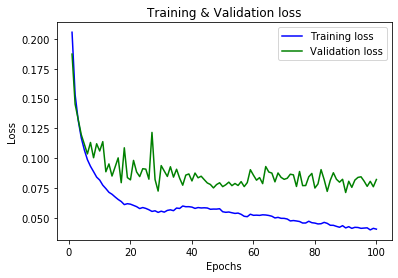

In [335]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1,len(loss_values)+1)
plt.plot(epochs,loss_values,'b',label='Training loss')
plt.plot(epochs,val_loss_values,'g',label='Validation loss')
plt.title('Training & Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

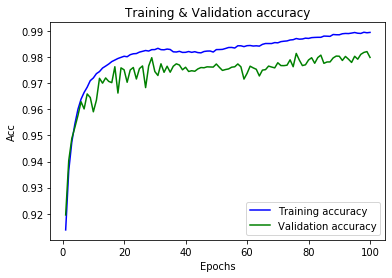

In [336]:
plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs,acc_values,'b',label='Training accuracy')
plt.plot(epochs,val_acc_values,'g',label='Validation accuracy')
plt.title('Training & Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

In [291]:
model1.fit(X_train, y_train, epochs=12)

Epoch 1/12
6402/6402 [==============================] - 6s 877us/step - loss: 0.1978 - accuracy: 0.9164
Epoch 2/12
6402/6402 [==============================] - 6s 967us/step - loss: 0.1441 - accuracy: 0.9417
Epoch 3/12
6402/6402 [==============================] - 6s 973us/step - loss: 0.1211 - accuracy: 0.9529
Epoch 4/12
6402/6402 [==============================] - 7s 1ms/step - loss: 0.1061 - accuracy: 0.9604
Epoch 5/12
6402/6402 [==============================] - 6s 893us/step - loss: 0.0965 - accuracy: 0.9651
Epoch 6/12
6402/6402 [==============================] - 6s 943us/step - loss: 0.0901 - accuracy: 0.9682
Epoch 7/12
6402/6402 [==============================] - 6s 879us/step - loss: 0.0847 - accuracy: 0.9705
Epoch 8/12
6402/6402 [==============================] - 6s 878us/step - loss: 0.0809 - accuracy: 0.9721
Epoch 9/12
6402/6402 [==============================] - 6s 871us/step - loss: 0.0772 - accuracy: 0.9733
Epoch 10/12
6402/6402 [==============================] - 6s 874us/

In [343]:
X_train,X_test,y_train,y_test = train_test_split(X_b,y_b,test_size=0.3)
model1.evaluate(X_test,y_test)

2744/2744 [==============================] - 2s 658us/step - loss: 0.0552 - accuracy: 0.9859


[0.05518481880426407, 0.9858872294425964]

### Convert probability from sigmoid function to labels

In [262]:
def discretization1(x):
    if x > 0.5: return 1
    else: return 0

              precision    recall  f1-score   support

           0       0.94      0.97      0.96     25067
           1       0.99      0.98      0.98     62726

    accuracy                           0.97     87793
   macro avg       0.97      0.97      0.97     87793
weighted avg       0.98      0.97      0.97     87793



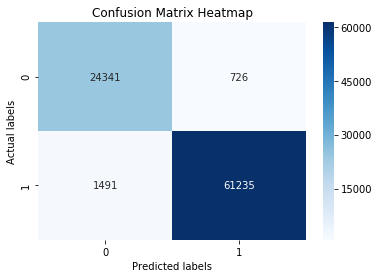

In [328]:
y_pd=pd.Series(y_pred.tolist()).apply(lambda x: x[0]).apply(lambda x: discretization1(x))
print(classification_report(y_test,y_pd))
matrix = confusion_matrix(y_test,y_pd)
ax = sns.heatmap(matrix, annot = True, fmt='d',xticklabels=['0','1'],yticklabels=['0','1'],cmap='Blues')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')
plt.show()